<a href="https://colab.research.google.com/github/h0806449f/TensorFlow/blob/main/Tibame_TensorFlow_NLP(imdb).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# 下載, 解壓縮 資料集
import tensorflow as tf

dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz", 
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
    extract=True,
)

In [10]:
# 檢視資料夾結構
import glob

glob.glob("/root/.keras/datasets/aclImdb/*")

glob.glob("/root/.keras/datasets/aclImdb/train/*")

['/root/.keras/datasets/aclImdb/train/unsupBow.feat',
 '/root/.keras/datasets/aclImdb/train/labeledBow.feat',
 '/root/.keras/datasets/aclImdb/train/urls_unsup.txt',
 '/root/.keras/datasets/aclImdb/train/urls_pos.txt',
 '/root/.keras/datasets/aclImdb/train/neg',
 '/root/.keras/datasets/aclImdb/train/pos',
 '/root/.keras/datasets/aclImdb/train/urls_neg.txt',
 '/root/.keras/datasets/aclImdb/train/unsup']

In [11]:
import os
import glob
import pandas as pd

def getdata(mid):
    dn = os.path.dirname(dataset)
    # 找出正面影評
    posfn = glob.glob(os.path.join(dn, "aclImdb", mid, "pos", "*"))

    # 找出負面影評
    negfn = glob.glob(os.path.join(dn, "aclImdb", mid, "neg", "*"))

    # 做成df
    contents = []
    for fn in posfn + negfn:
        with open(fn, encoding="utf-8") as f:
            contents.append(f.read())
    df = pd.DataFrame({
        "content":contents,
        "sentiment":[1] * len(posfn) + [0] * len(negfn)
    })
    
    return df

train_df = getdata("train")
test_df = getdata("test")

In [12]:
# 檢查df
train_df, test_df

(                                                 content  sentiment
 0      well, this is an Ivan Reitman film. with the r...          1
 1      A very engaging, intelligent, and well-made fi...          1
 2      This Columbo episode is probably noted more fo...          1
 3      Very well done and spooky horror movie from po...          1
 4      When you are in a gloomy or depressed mood, go...          1
 ...                                                  ...        ...
 24995  Turkish Cinema has a big problem. Directors ar...          0
 24996  "The house of the spirits" is quite awful. I l...          0
 24997  Most of the episodes on Season 1 are awful..Th...          0
 24998  Jewish newspaper reporter Justin Timberlake (a...          0
 24999  In spite of sterling work by the supporting ac...          0
 
 [25000 rows x 2 columns],
                                                  content  sentiment
 0      Not every line in a comedy is funny. This movi...          1
 1   

# 語言相關模型
1. 機器學習, 單純貝氏使用機率, 將各個詞的出現機率視為獨立事件, 單獨判斷  
    判斷後, 再將機率相乘
2. 深度學習 -> 語意(情緒波動)  
    2.1 上下文語意 (word2vec)  
    2.2 主題語意 : 語意的具象化, 向量化  
    3.3 上面兩種結合 : BERT  
  
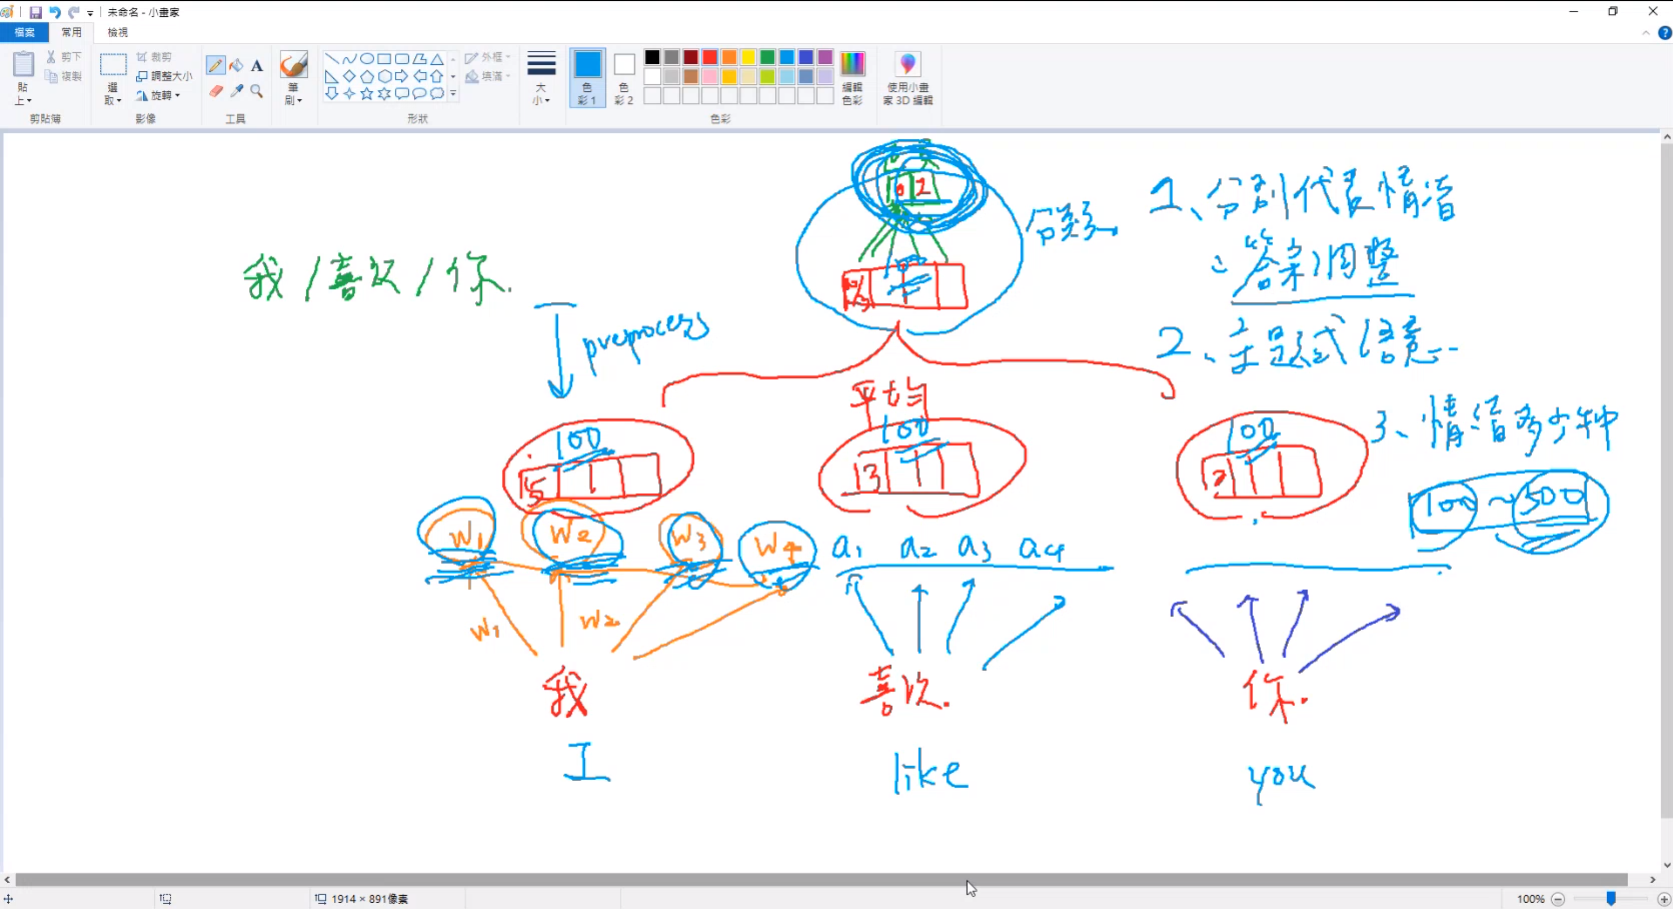

# 建立模型

Embedding : https://keras.io/zh/layers/embeddings/  
1. 詞彙數量從1開始, 
2. 0 的作用 -> padding
3. input dim -> 有幾種常用詞彙
4. input length -> 某篇文章, 用到多少詞彙 -> 會有不同長度的文章, 所以需要補齊

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

layers = [
    Embedding(input_dim=3001,  # 3000常用詞彙 + 1 padding (0)
      output_dim=100,  # 每個詞彙, 都轉化成 100種語意 向量
      mask_zero=True,  # 不將 0 當作語意判斷
      input_length=512  # 每篇文章, 只取512個, 有出現在常用詞彙 的詞
     ),
    GlobalAveragePooling1D(),
    Dense(2, activation="softmax")
]

model = Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 100)          300100    
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 300,302
Trainable params: 300,302
Non-trainable params: 0
_________________________________________________________________


In [16]:
# summary 解析
# 1. 3001 常用詞彙
# 2. 100 詞彙向量
# 3. 3001 * 100 = 300100
# 4. NLP 不需要激活函式

In [15]:
# compile
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(loss=SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
        optimizer="adam")

# 資料預處理

In [19]:
# 建立一個 3000 常用詞彙字典
# Tokenizer : 將 3000常用詞彙 換成數字
from tensorflow.keras.preprocessing.text import Tokenizer

tok = Tokenizer(num_words=3000)

tok.fit_on_texts(train_df["content"])

In [30]:
# 檢視 3000 查用詞彙
tok.word_index

# 字典形式
tok.index_word[1]

# 檢查有無特定詞彙 (這邊用來檢查有無換行符號 or ,)
tok.word_index["hate"]

782

In [33]:
# Sequenize : 把我的字, 轉換成數字 (利用剛剛列表)
import pandas as pd

x_train_seq = tok.texts_to_sequences(train_df["content"])  # 超過 3000 常用詞彙列表的字 會自動被忽略掉
x_test_seq = tok.texts_to_sequences(test_df["content"])

pd.DataFrame(x_train_seq)

,0,1,2,3,4,5,6,7,8,9,...,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815
0,70,11,6,32,19,16,1,1278,1395.0,1229.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,52,1724,1086,2,70,90,19,2.0,1751.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11,2525,387,6,239,50,15,1,164.0,2148.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,52,70,221,2,186,17,36,19,1166.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51,22,23,8,3,39,1306,137,103.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,434,44,3,191,436,904,710,924,8.0,434.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24996,1,310,4,1,6,176,370,10,409.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24997,88,4,1,669,20,809,297,23,370.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24998,2919,2424,14,6,51,3,1290,22,5.0,1906.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# (https://keras.io/zh/preprocessing/sequence/)

x_train_pad = pad_sequences(x_train_seq, maxlen=512)  # 文章只取512個字, 文章不足512字
x_test_pad = pad_sequences(x_test_seq, maxlen=512)  # 就在前面補0 (padding="pre", truncating="pre")

# check
pd.DataFrame(x_train_pad)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0,0,0,0,0,0,0,0,0,0,...,70,14,33,97,3,4,110,16,3,1005
1,0,0,0,0,0,0,0,0,0,0,...,77,354,146,171,2,171,28,4,58,2628
2,0,0,0,0,0,0,0,0,0,0,...,4,2525,2,24,60,309,16,794,37,543
3,0,0,0,0,0,0,0,0,0,0,...,24,1177,2718,267,2,1391,6,1128,14,1
4,0,0,0,0,0,0,0,0,0,0,...,30,277,8,1,169,102,30,1,169,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,0,...,37,3,7,7,435,4,275,435,4,55
24996,0,0,0,0,0,0,0,0,0,0,...,180,22,212,27,21,61,18,5,126,1656
24997,0,0,0,0,0,0,0,0,0,0,...,74,125,16,1294,2,502,12,314,22,1531
24998,0,0,0,0,0,0,0,0,0,0,...,7,7,785,2764,625,1462,644,1462,2023,2836


In [ ]:
# 25000 篇文章
# 每篇文章取512字  (不足512字, 則在前方補0)
# 將512個文字, 換成3000常用詞彙列表中的號碼

In [44]:
import numpy as np

y_train = np.array(train_df["sentiment"])
y_test = np.array(test_df["sentiment"])

In [45]:
# fit
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    ModelCheckpoint("imdb_NLP.h5", save_best_only=True),
    EarlyStopping(patience=7, restore_best_weights=True)
]

model.fit(x_train_pad,
      y_train,
      batch_size=100,
      epochs=40,
      validation_split=0.1,
      callbacks=callbacks)

Epoch 1/40
225/225 [==============================] - 8s 30ms/step - loss: 0.5854 - accuracy: 0.7044 - val_loss: 0.5298 - val_accuracy: 0.7424
Epoch 2/40
225/225 [==============================] - 6s 28ms/step - loss: 0.3800 - accuracy: 0.8580 - val_loss: 0.4521 - val_accuracy: 0.7868
Epoch 3/40
225/225 [==============================] - 6s 29ms/step - loss: 0.3041 - accuracy: 0.8840 - val_loss: 0.3733 - val_accuracy: 0.8360
Epoch 4/40
225/225 [==============================] - 6s 28ms/step - loss: 0.2701 - accuracy: 0.8965 - val_loss: 0.3448 - val_accuracy: 0.8512
Epoch 5/40
225/225 [==============================] - 6s 28ms/step - loss: 0.2498 - accuracy: 0.9033 - val_loss: 0.3176 - val_accuracy: 0.8624
Epoch 6/40
225/225 [==============================] - 6s 28ms/step - loss: 0.2361 - accuracy: 0.9088 - val_loss: 0.3212 - val_accuracy: 0.8656
Epoch 7/40
225/225 [==============================] - 6s 29ms/step - loss: 0.2265 - accuracy: 0.9134 - val_loss: 0.3056 - val_accuracy: 0.8748

In [46]:
# evaluate
model.evaluate(x_test_pad, y_test)

782/782 [==============================] - 5s 6ms/step - loss: 0.2885 - accuracy: 0.8818


[0.2884601950645447, 0.8817999958992004]

In [47]:
review = ""#@param {type:"string"}

seq = tok.texts_to_sequences([review]) # 注意shape

pad = pad_sequences(seq, maxlen=512)

pre = model.predict(pad)

prob = pre[0]

trans = ["neg", "pos"]

for p, label in zip(prob, trans):
    print(label, "的機率是", p)

1/1 [==============================] - 0s 91ms/step
neg 的機率是 0.90460205
pos 的機率是 0.09539793
